In [1]:
import emcee
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import corner

In [2]:
from surp import subgiants
import surp
import vice
from surp import gce_math as gcem
import arya

/users/PAS2232/aeyobd/VICE/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


In [3]:
from dataclasses import dataclass

In [5]:
@dataclass
class sz_params:
    η: float = 0.5
    r: float = 0.4
    τ_star: float = 2
        
    t_d_agb: float = 0.1
    τ_agb: float = 0.1
        
    y_c_agb: float = 2.85e-3 * 0.2
    y_c_cc: float = 2.85e-3 * 0.8
    ζ_c_agb: float = 0
    ζ_c_cc: float = 0.029
        
    y_o = vice.yields.ccsne.settings["o"]
    y_fe_cc: float = vice.yields.ccsne.settings["fe"]
    y_fe_ia: float = vice.yields.sneia.settings["fe"]
        
    τ_ia: float = 1.5
    κ_ia: float = -1.1
    t_d_ia: float = 0.15
        
    t_end: float = 13.2
    
        
    @property 
    def ϖ(self):
        return 1 / self.τ_dep
    
    @property
    def τ_dep(self):
        return self.τ_star / (1 + self.η - self.r)

In [6]:
def ϵ(t):
    return np.exp(-t)

def ξ(t):
    return t*np.exp(-t)

In [7]:
def cc_model(t, y, params = sz_params()):
    ϖ = params.ϖ
    s = 1 - ϵ(ϖ * t)
    return y / params.τ_star * s / ϖ


def fe_ia_model(t, params = sz_params()):
    ϖ = params.ϖ
    ι = 1 / params.τ_ia
    
    δt = t - params.t_d_ia
    
    s = 1 
    s += - ϖ/(ϖ - ι) * ϵ(ι * δt)
    s += + ι/(ϖ - ι) * ϵ(ϖ * δt)
    s = np.where(δt <= 0, 0, s)
    
    Zeq = params.y_fe_ia / params.τ_star  / ϖ
    return Zeq * s


def Γ(κ, t):
    return -gammainc(κ, t)


def R_int_ia(t, params=sz_params()):
    κ = params.κ_ia
    t_d = params.t_d_ia    
    R0 = (κ + 1) / (params.t_end**(κ + 1) - t_d**(κ + 1))

    r = t**(κ+1) - t_d**(κ+1)
    return r * R0 / (κ + 1)

def fe_ia_model2(t, params=sz_params()):
    ϖ = params.ϖ
    κ = params.κ_ia
    t_d = params.t_d_ia
    
    t = np.array(t)
    
    Zeq = params.y_fe_ia / params.τ_star * 1 / ϖ
    R0 = (κ + 1) / (0 - t_d**(κ + 1))
    
    Γ0 = Γ(κ+2, -ϖ*t_d)
    coef = (-ϖ)**(-κ - 1)
    c = np.array([
        float(
            (coef * (Γ(κ+2, -ϖ*x) - Γ0)
            ).real) for x in t])
    
    i = np.array([
        float(
            (coef * (Γ(κ+2, -ϖ*x) - Γ0)
            ).imag) for x in t])
    
    s =  -ϵ(ϖ*t) * c
    s += -t_d**(κ + 1) * (1 - ϵ(ϖ*t - ϖ*t_d))
    
    s = np.where(t >= t_d, s, 0)

    return s * Zeq  * R0 / (κ + 1)

def fe_model(t, params=sz_params()):
    Zcc = cc_model(t, params.y_fe_cc, params)
    Zia = fe_ia_model(t, params)
    
    return Zcc + Zia


In [8]:
def c_agb_model(t, params=sz_params()):
    α = 1/params.τ_agb
    ϖ = params.ϖ
    δt = t - params.t_d_agb
    
    s = 1 / ϖ 
    s += 1/(α - ϖ) * ξ(α * δt)
    s += (2*α- ϖ) / (α - ϖ)**2 * ϵ(α * δt)
    s += -(1/ϖ + (2*α- ϖ) / (α - ϖ)**2) * ϵ(ϖ * δt)
    
    s = np.where(δt < 0, 0, s)

    return params.y_c_agb * s / params.τ_star



def c_model(t, params=sz_params()):
    Zagb = c_agb_model(t, params)
    Zcc = cc_model(t, params.y_c_cc, params)
    return Zagb + Zcc

In [9]:
def o_model(t, params=sz_params()):
    return cc_model(t, params.y_o)

In [10]:
def prob(x, y, xerr, yerr, xm, ym):
    return np.exp(-1/2 * ((y - ym)**2/yerr**2 + (x-xm)**2/xerr**2))

In [11]:
def log_prob(obs, model):
    x, y, xerr, yerr = obs
    xm, ym, w = model
    xm = xm.reshape((-1, 1))
    ym = ym.reshape((-1, 1))
    w = w.reshape((-1, 1)) 
    Σs = np.sum(w * prob(x, y, xerr, yerr, xm, ym), axis=0) # sum over model
    return np.sum(np.log(Σs)) # return log product of each data point
    
    

In [12]:
log_prob(obs, calc_model(sz_params))

NameError: name 'obs' is not defined

In [13]:
def calc_model(params, t = np.linspace(0.01, 13.2, 1000)):
    zo_a = o_model(t, params)
    zfe_a = fe_model(t, params)
    zc_a = c_model(t, params)

    o_h_a = gcem.abund_to_brak(zo_a, "o")
    c_o_a = gcem.abund_to_brak(zc_a/zo_a, "c", "o")
    o_fe_a = gcem.abund_to_brak(zo_a/zfe_a, "o", "fe")
    
    return o_fe_a, c_o_a, np.ones(len(t))

In [14]:
def normal(x, mu, sigma):
    return 1/np.sqrt(2*np.pi * sigma**2) * np.exp(-(x-mu)**2 / (2*sigma**2))

In [15]:
def log_normal(x, mu, sigma):
    return np.where(x >= 0, normal(np.log(x), np.log(mu), sigma), 0)

In [16]:
x_m = np.linspace(-2, 5, 1000)

In [19]:
y_c_tot = 2.85e-3

In [20]:
def get_params(theta):
    η, τ_agb, f_agb = theta
    y_c_cc = (1-f_agb) * y_c_tot
    y_c_agb = f_agb * y_c_tot
    
    return sz_params(η=η, τ_star=2, τ_agb=τ_agb, y_c_cc=y_c_cc, y_c_agb=y_c_agb)

def get_theta(params=sz_params()):
    f = params.y_c_agb/(params.y_c_agb + params.y_c_agb)
    return np.array([params.η, params.τ_agb, f])

def log_prior(theta):
    params = get_params(theta)
    p = 0
    
    p += np.log(log_normal(params.η, 0.5, 2))
    p += np.log(log_normal(params.τ_star, 2, 0.5))
    p += np.log(log_normal(params.τ_agb, 0.3, 0.5))
    p += np.log(normal(params.y_c_cc + params.y_c_agb, 1e-4, 2))

    return p

def log_likelihood(theta, obs):
    params = get_params(theta)
    model = calc_model(params)
    return log_prob(obs, model) + log_prior(theta)

In [21]:
x = subgiants.MG_FE
y = subgiants.C_MG
xerr = subgiants.MG_FE_ERR
yerr = subgiants.C_MG_ERR

filt = ~np.isnan(x)
filt &= ~np.isnan(y)
filt &= ~np.isnan(xerr)
filt &= ~np.isnan(yerr)

x = x[filt].values
y = y[filt].values
xerr = xerr[filt].values
yerr = yerr[filt].values

obs = [x, y, xerr, yerr]

In [22]:
nll = lambda args, obs: -log_likelihood(args, obs)

th0 = get_theta()
Nparams = len(th0)

initial = th0 * (1 +  0.02 * np.random.randn(Nparams))
soln = minimize(nll, initial, args=obs)

/tmp/slurmtmp.27479547/ipykernel_50496/2757378618.py:8: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(Σs)) # return log product of each data point
/users/PAS2232/aeyobd/.local/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/tmp/slurmtmp.27479547/ipykernel_50496/2757378618.py:8: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(Σs)) # return log product of each data point


In [23]:
def plot_model(theta, **kwargs):
    params = get_params(theta)
    x, y, w = calc_model(params)
    plt.plot(x, y, **kwargs)

(-0.5, 0.2)

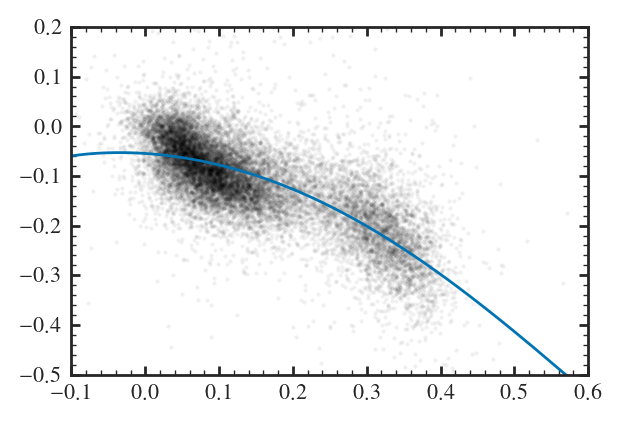

In [24]:
plt.scatter(x, y, s=0.3, alpha=0.05, color="k")
plot_model(soln.x)
plt.xlim(-0.1, 0.6)
plt.ylim(-0.5, 0.2)

In [25]:
Nwalkers = 2*Nparams
pos = initial* (1 + 0.01 * np.random.randn(Nwalkers, Nparams))

sampler = emcee.EnsembleSampler(
    Nwalkers, Nparams, log_likelihood, args=[obs]
)
sampler.run_mcmc(pos, 100, progress=True)

 31%|███       | 31/100 [01:17<02:50,  2.47s/it]/users/PAS2232/aeyobd/surp/surp/gce_math.py:80: RuntimeWarning: invalid value encountered in log10
  return np.log10(data) - np.log10(vice.solar_z(ele) / vice.solar_z(ele2))
 31%|███       | 31/100 [01:20<02:59,  2.60s/it]


ValueError: Probability function returned NaN

In [ ]:
flat_samples = sampler.get_chain(discard=10, thin=1, flat=True)

In [ ]:
fig = corner.corner(flat_samples, labels=[r"$\eta$", r"$\tau_{agb}$", r"$f_{\rm agb}$"]);

In [ ]:
for i in range(len(flat_samples)):
    plot_model(flat_samples[i, :], alpha=0.01, color="blue")

plt.scatter(x, y, s=0.3, alpha=0.05, color="k")
arya.medianplot(subgiants, "MG_FE", "C_MG", binsize=100)
plt.xlim(-0.1, 0.6)
plt.ylim(-0.5, 0.2)